In [40]:
import numpy as np
import os
import PIL
import PIL.Image

import tensorflow as tf
# import tensorflow_datasets as tfds
# from tf.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout, Reshape
import matplotlib.pyplot as plt

# import sklearn
# from sklearn.datasets import fetch_lfw_people      ######
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report, log_loss, accuracy_score
# from sklearn.model_selection import train_test_split

In [70]:
import pathlib
# download Labeled Face in The Wild datasets
dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [71]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13233


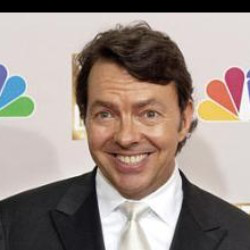

In [94]:
#@title ALan Ball
AB = list(data_dir.glob('Alan_Ball/*'))
PIL.Image.open(str(AB[0]))

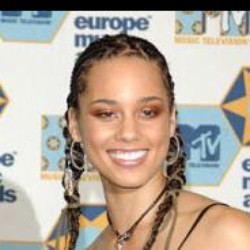

In [95]:
#@title Alicia Keys
AK = list(data_dir.glob('Alicia_Keys/*'))
PIL.Image.open(str(AK[0]))

*   80% training 
*   20% validation

The image_batch is a tensor of the shape (32, 250, 250, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [72]:
# define batch size and image size
batch_size = 32
img_height = 250
img_width = 250

In [73]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 9264 files for training.


In [74]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13233 files belonging to 5749 classes.
Using 3969 files for validation.


In [75]:
# class names
class_names = train_ds.class_names
print(class_names[1000])

num_class= len(class_names)

Ciaran_Hinds


## Visualizing the dataset
#### the first 9 images from the training dataset

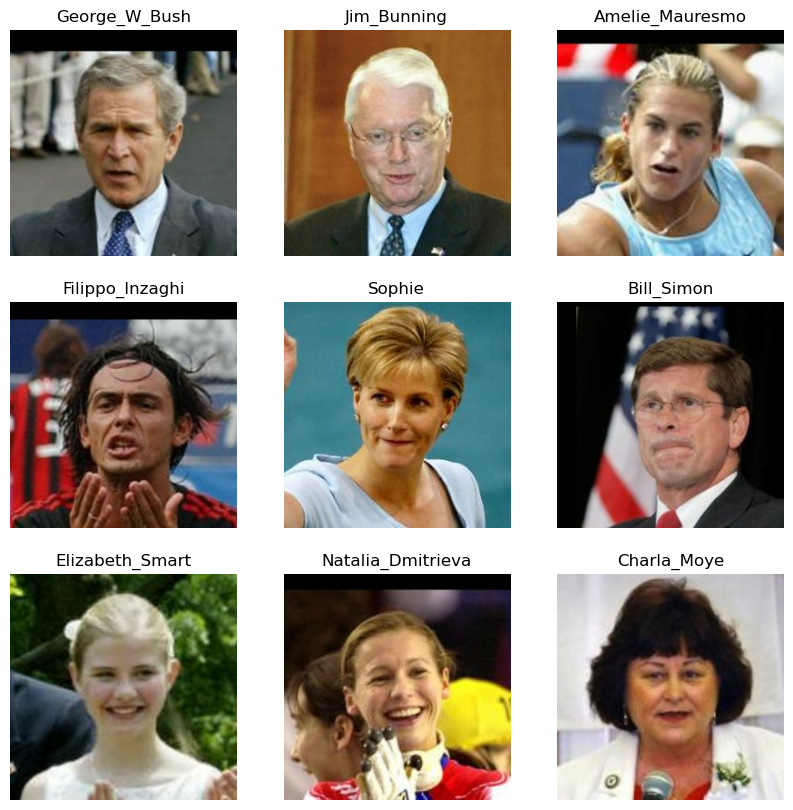

In [76]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Standardize the data 

convert RGG channel's range [0 - 255] -> [0 - 1]

In [77]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [78]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training the model 

experimental model that i come up with. We will see how it does

In [121]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax'),


])

`tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [122]:
# model.summary()
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [123]:
his = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=35
)

Epoch 1/35
331/331 [==============================] - 154s 462ms/step - loss: 8.1749 - accuracy: 0.0377 - val_loss: 7.9511 - val_accuracy: 0.0457
Epoch 2/35
331/331 [==============================] - 155s 469ms/step - loss: 7.1328 - accuracy: 0.0383 - val_loss: 8.5480 - val_accuracy: 0.0461
Epoch 3/35
331/331 [==============================] - 153s 461ms/step - loss: 6.6891 - accuracy: 0.0375 - val_loss: 9.1842 - val_accuracy: 0.0476
Epoch 4/35
331/331 [==============================] - 153s 461ms/step - loss: 6.3981 - accuracy: 0.0374 - val_loss: 10.2936 - val_accuracy: 0.0450
Epoch 5/35
331/331 [==============================] - 152s 458ms/step - loss: 6.1752 - accuracy: 0.0364 - val_loss: 12.0105 - val_accuracy: 0.0423
Epoch 6/35
331/331 [==============================] - 153s 461ms/step - loss: 5.9888 - accuracy: 0.0351 - val_loss: 16.7799 - val_accuracy: 0.0416
Epoch 7/35
331/331 [==============================] - 153s 462ms/step - loss: 5.8999 - accuracy: 0.0355 - val_loss: 15.08

In [124]:
# summary of the model 
model.summary()

# print accuracy of the model
loss, acc = model.evaluate(val_ds)
print("Accuracy:", acc)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 124, 124, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 61, 61, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 59, 59, 128)     

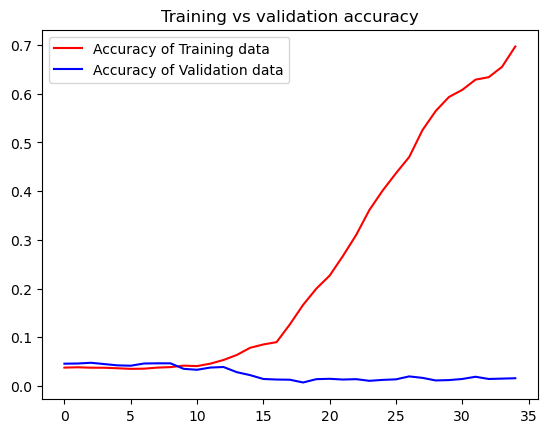

<Figure size 640x480 with 0 Axes>

In [125]:
# plot training accuracy vs validation accuracy 

get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

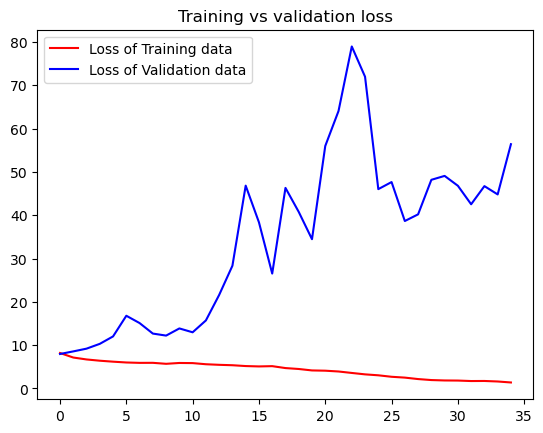

<Figure size 640x480 with 0 Axes>

In [126]:
# plot training loss vs validation loss

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Make changes

## Changing the infrastructure 

In [109]:
model = Sequential()

model.add(normalization_layer),
model.add(Conv2D(32,(3,3), input_shape=(250,250,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=num_class, activation='softmax'))

In [110]:
# model.summary()
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [111]:
his = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=35
)

Epoch 1/35
331/331 [==============================] - 101s 303ms/step - loss: 8.1827 - accuracy: 0.0368 - val_loss: 7.9368 - val_accuracy: 0.0457
Epoch 2/35
331/331 [==============================] - 104s 313ms/step - loss: 7.0279 - accuracy: 0.0372 - val_loss: 8.4474 - val_accuracy: 0.0454
Epoch 3/35
331/331 [==============================] - 103s 310ms/step - loss: 6.6688 - accuracy: 0.0389 - val_loss: 9.2957 - val_accuracy: 0.0416
Epoch 4/35
331/331 [==============================] - 102s 308ms/step - loss: 6.3894 - accuracy: 0.0376 - val_loss: 8.8218 - val_accuracy: 0.0435
Epoch 5/35
331/331 [==============================] - 100s 303ms/step - loss: 6.4879 - accuracy: 0.0365 - val_loss: 8.8990 - val_accuracy: 0.0446
Epoch 6/35
331/331 [==============================] - 99s 300ms/step - loss: 6.2061 - accuracy: 0.0382 - val_loss: 10.2947 - val_accuracy: 0.0461
Epoch 7/35
331/331 [==============================] - 100s 303ms/step - loss: 6.1221 - accuracy: 0.0396 - val_loss: 10.8095 

In [113]:
# summary of the model 
model.summary()

# print accuracy of the model
loss, acc = model.evaluate(val_ds)
print("Accuracy:", acc)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 119072)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)              

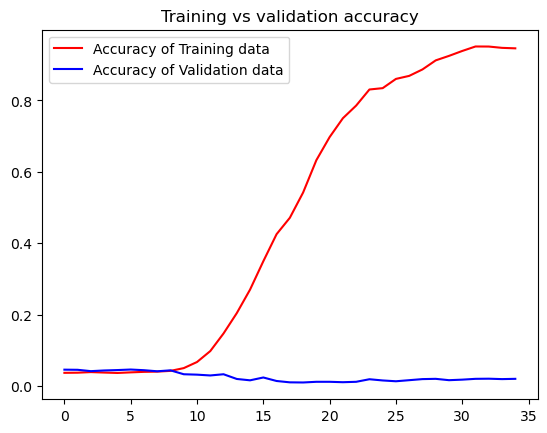

<Figure size 640x480 with 0 Axes>

In [114]:
# plot training accuracy vs validation accuracy 

get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

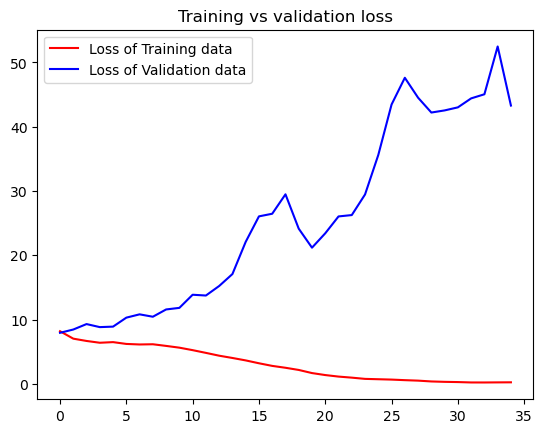

<Figure size 640x480 with 0 Axes>

In [115]:
# plot training loss vs validation loss

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Reduce complexity of the model 

In [130]:
model = Sequential()

model.add(normalization_layer),
model.add(Conv2D(32,(3,3), input_shape=(250,250,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=num_class, activation='softmax'))

In [131]:

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [132]:
his = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40
)

Epoch 1/40
331/331 [==============================] - 73s 217ms/step - loss: 8.2099 - accuracy: 0.0382 - val_loss: 8.0302 - val_accuracy: 0.0457
Epoch 2/40
331/331 [==============================] - 71s 216ms/step - loss: 7.5356 - accuracy: 0.0374 - val_loss: 8.2101 - val_accuracy: 0.0438
Epoch 3/40
331/331 [==============================] - 72s 218ms/step - loss: 7.2095 - accuracy: 0.0383 - val_loss: 8.8819 - val_accuracy: 0.0435
Epoch 4/40
331/331 [==============================] - 73s 219ms/step - loss: 6.9437 - accuracy: 0.0381 - val_loss: 10.4300 - val_accuracy: 0.0420
Epoch 5/40
331/331 [==============================] - 72s 218ms/step - loss: 6.8504 - accuracy: 0.0395 - val_loss: 11.9682 - val_accuracy: 0.0367
Epoch 6/40
331/331 [==============================] - 72s 218ms/step - loss: 6.5386 - accuracy: 0.0404 - val_loss: 13.8795 - val_accuracy: 0.0359
Epoch 7/40
331/331 [==============================] - 72s 217ms/step - loss: 6.2152 - accuracy: 0.0452 - val_loss: 10.4815 - va

In [133]:
# summary of the model 
model.summary()

# print accuracy of the model
loss, acc = model.evaluate(val_ds)
print("Accuracy:", acc)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_14 (ModuleWra (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 119072)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)              

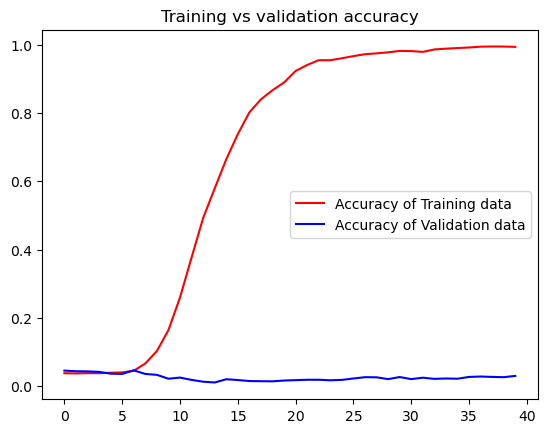

<Figure size 640x480 with 0 Axes>

In [134]:
# plot training accuracy vs validation accuracy 

get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

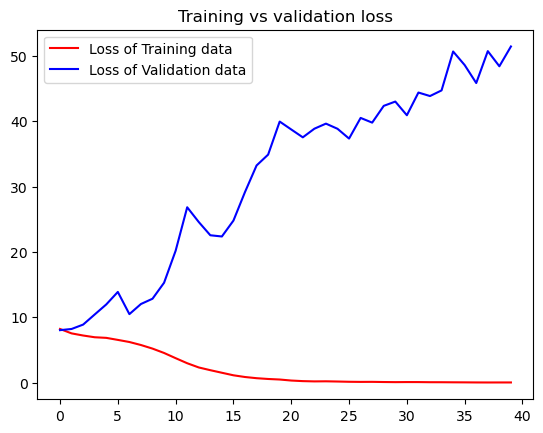

<Figure size 640x480 with 0 Axes>

In [135]:
# plot training loss vs validation loss

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Add regularizzation(s)

In [136]:
# Add dropout to the model 
model = Sequential()

model.add(normalization_layer),
model.add(Conv2D(32,(3,3), input_shape=(250,250,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=num_class, activation='softmax'))

In [137]:

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [138]:
his = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=35
)

Epoch 1/35


c:\Users\badji\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


331/331 [==============================] - 78s 234ms/step - loss: 8.2479 - accuracy: 0.0366 - val_loss: 8.0127 - val_accuracy: 0.0457
Epoch 2/35
331/331 [==============================] - 76s 231ms/step - loss: 7.8808 - accuracy: 0.0384 - val_loss: 8.0799 - val_accuracy: 0.0457
Epoch 3/35
331/331 [==============================] - 76s 229ms/step - loss: 7.7328 - accuracy: 0.0381 - val_loss: 8.1132 - val_accuracy: 0.0457
Epoch 4/35
331/331 [==============================] - 76s 230ms/step - loss: 7.5458 - accuracy: 0.0387 - val_loss: 8.2159 - val_accuracy: 0.0457
Epoch 5/35
331/331 [==============================] - 78s 235ms/step - loss: 7.3307 - accuracy: 0.0382 - val_loss: 8.2070 - val_accuracy: 0.0457
Epoch 6/35
331/331 [==============================] - 78s 236ms/step - loss: 7.0495 - accuracy: 0.0398 - val_loss: 9.2769 - val_accuracy: 0.0457
Epoch 7/35
331/331 [==============================] - 76s 231ms/step - loss: 6.7237 - accuracy: 0.0442 - val_loss: 8.6547 - val_accuracy: 0.0

In [139]:
# summary of the model 
model.summary()

# print accuracy of the model
loss, acc = model.evaluate(val_ds)
print("Accuracy:", acc)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_15 (ModuleWra (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 119072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 119072)          

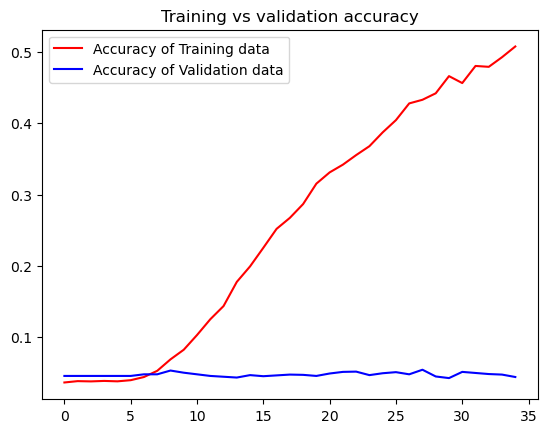

<Figure size 640x480 with 0 Axes>

In [140]:
# plot training accuracy vs validation accuracy 

get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

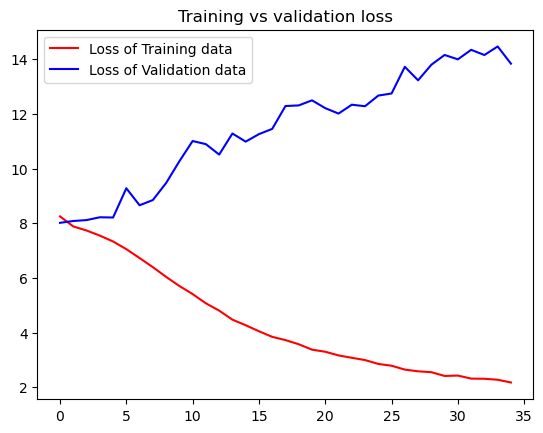

<Figure size 640x480 with 0 Axes>

In [141]:
# plot training loss vs validation loss

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Preprocess the dataset

In [79]:
def resize_image(image):
  image = tf.image.central_crop(image, central_fraction=0.5)
  return image

processed_train_ds = train_ds.map(lambda x, y: (resize_image(x), y))
processed_val_ds = val_ds.map(lambda x, y: (resize_image(x), y))

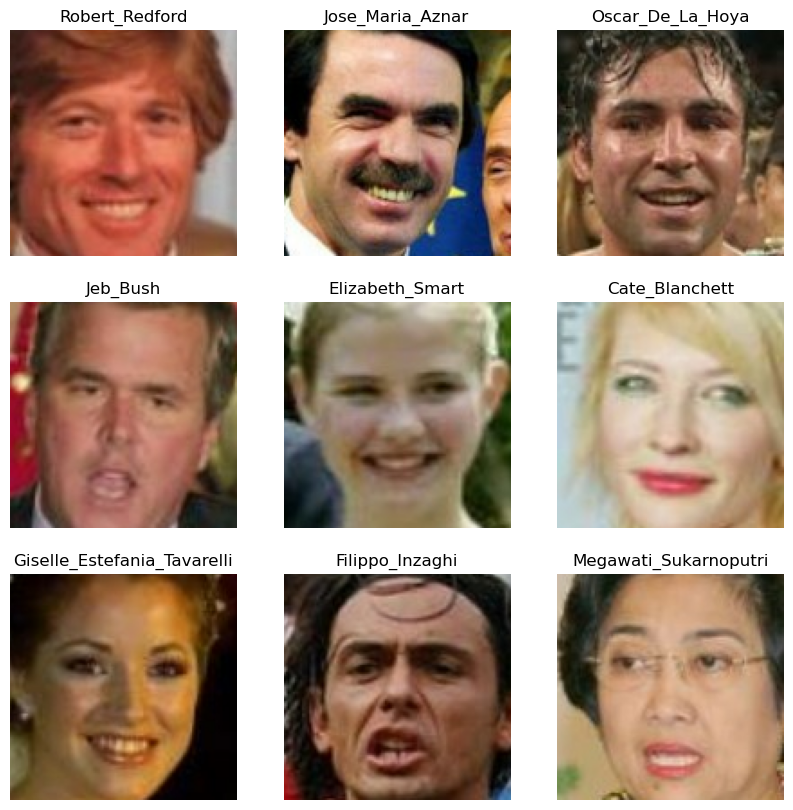

In [80]:
plt.figure(figsize=(10, 10))
for images, labels in processed_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

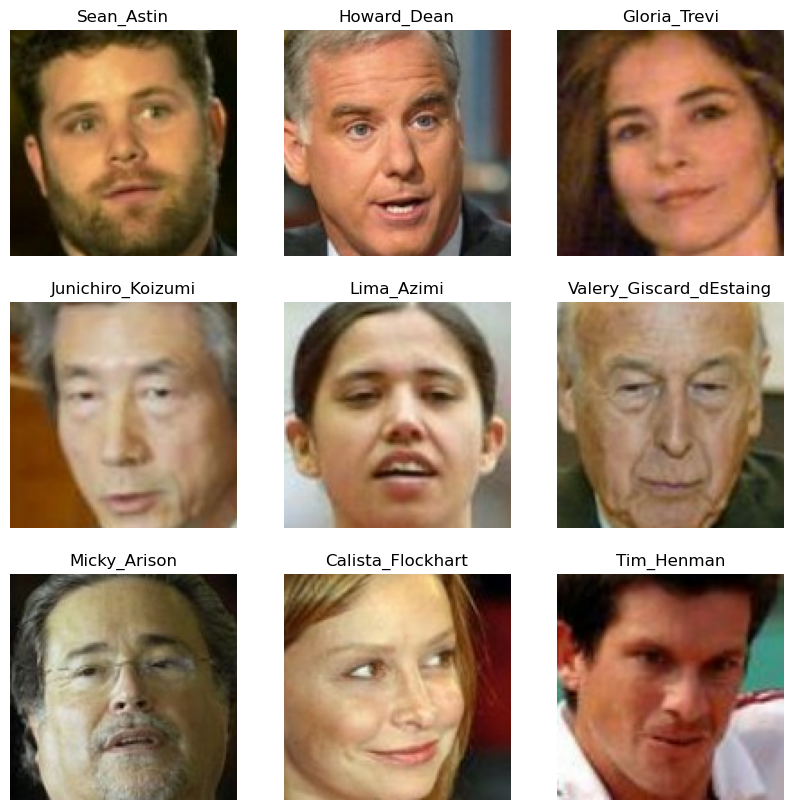

In [81]:
plt.figure(figsize=(10, 10))
for images, labels in processed_val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [67]:
model = Sequential()

model.add(normalization_layer),
model.add(Conv2D(32,(3,3), input_shape=(250,250,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), input_shape=(250,250,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), input_shape=(250,250,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
# model.add(Dropout(0.5))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(units=num_class, activation='softmax'))

In [68]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
his = model.fit(
  processed_train_ds,
  validation_data=processed_val_ds,
  epochs=35
)

### preprocess the dataset